In [1]:
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

2025-04-12 15:58:08.959346: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744473489.365628      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744473489.480469      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def load_data(image_size, labels, base_path):
    X = []
    Y = []
    for label in labels:
        folderPath = os.path.join(base_path, label)
        for img_name in os.listdir(folderPath):
            img_path = os.path.join(folderPath, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (image_size, image_size))
            X.append(img)
            Y.append(labels.index(label))
    return np.array(X), np.array(Y)

In [3]:
image_size = 224
labels = ['covid', 'pneumonia']
base_path = '/kaggle/input/covid-pneumonia-lus-images/covid_pneumonia'

# Load data
X, Y = load_data(image_size, labels, base_path)

X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)



In [6]:
# Data Augmentation & Normalisation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    preprocessing_function=lambda x: (x - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]  # ImageNet normalization
)
val_datagen = ImageDataGenerator(
    preprocessing_function=lambda x: (x - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]
)

In [7]:
early_stop = EarlyStopping(
    monitor='val_loss',    # What to monitor (e.g., 'val_loss' or 'val_accuracy')
    patience=5,            # Number of epochs to wait before stopping after no improvement
    restore_best_weights=True  # Revert to best weights (optional but useful)
)

In [9]:
def build_and_train_model_kfold(base_model, X, Y, X_test, Y_test, labels, model_name, k_folds=5):
    # Use MirroredStrategy for multi-GPU training
    strategy = tf.distribute.MirroredStrategy()
    print(f"Number of devices: {strategy.num_replicas_in_sync}")

    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    fold_accuracies = []
    fold_losses = []
    conf_matrices = []
    training_times = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
        print(f"\nTraining Fold {fold + 1}/{k_folds}...\n")

        # Splitting the dataset for this fold
        X_train, X_val = X[train_idx], X[val_idx]
        Y_train, Y_val = Y[train_idx], Y[val_idx]

        # Define and build model within strategy scope
        with strategy.scope():
            model = Sequential([
                base_model,
                Flatten(),
                Dense(512, activation='relu'),
                Dropout(0.4),
                Dense(1, activation='sigmoid')
            ])
            optimizer = Adam(learning_rate=0.0001)
            model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        # Train the model on GPUs
        start_time = time.time()
        with strategy.scope():
            history = model.fit(
                train_datagen.flow(X_train, Y_train, batch_size=32 * strategy.num_replicas_in_sync),
                epochs=5,
                validation_data=val_datagen.flow(X_val, Y_val),
                verbose=1
            )
        training_time = time.time() - start_time
        training_times.append(training_time)

        # Evaluate on validation set
        val_loss, val_accuracy = model.evaluate(X_val, Y_val, verbose=1)
        fold_accuracies.append(val_accuracy)
        fold_losses.append(val_loss)

        print(f"Fold {fold + 1} Validation Accuracy: {val_accuracy:.4f}")
        print(f"Fold {fold + 1} Validation Loss: {val_loss:.4f}")

    # Train final model on full training set
    print("\nTraining Final Model on Full Dataset...\n")
    with strategy.scope():
        model = Sequential([
            base_model,
            Flatten(),
            Dense(512, activation='relu'),
            Dropout(0.4),
            Dense(1, activation='sigmoid')
        ])
        optimizer = Adam(learning_rate=0.0001)
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    start_time = time.time()
    with strategy.scope():
        history = model.fit(train_datagen.flow(X_train, Y_train, batch_size=32 * strategy.num_replicas_in_sync),
                            epochs=20,
                            validation_data=val_datagen.flow(X_val, Y_val),
                            callbacks=[early_stop])
    training_time = time.time() - start_time

    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=1)
    print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")
    print(f'Final Test Loss: {test_loss:.4f}')

    # Confusion Matrix and Classification Report
    Y_pred = model.predict(X_test)
    Y_pred_classes = (Y_pred > 0.5).astype(int)

    conf_matrix = confusion_matrix(Y_test, Y_pred_classes)
    class_report = classification_report(Y_test, Y_pred_classes, target_names=labels)

    print(f'\nClassification Report for {model_name}:')
    print(class_report)

    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    # Summary of K-Fold Results
    avg_accuracy = np.mean(fold_accuracies)
    avg_loss = np.mean(fold_losses)
    avg_time = np.mean(training_times)

    print(f"\nAverage Validation Accuracy across {k_folds} folds: {avg_accuracy:.4f}")
    print(f"Average Validation Loss across {k_folds} folds: {avg_loss:.4f}")
    print(f"Average Training Time per fold: {avg_time:.2f} seconds")

    return history, avg_accuracy, avg_loss, conf_matrix, class_report, Y_test, Y_pred_classes

Number of devices: 2

Training Fold 1/5...

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.6497 - loss: 3.6514 - val_accuracy: 0.9241 - val_loss: 0.3166
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 547ms/step - accuracy: 0.8635 - loss: 1.0058 - val_accuracy: 0.9494 - val_loss: 0.1326
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 529ms/step - accuracy: 0.9287 - loss: 0.3957 - val_accuracy: 0.9873 - val_loss: 0.1617
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 528ms/step - accuracy: 0.9396 - loss: 0.2097 - val_accuracy: 0.9873 - val_loss: 0.0198
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 516ms/step - accuracy: 0.9713 - loss: 0.1066 - val_accuracy: 0.9747 - val_loss: 0.1559
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.7966 - loss: 0.5250
Fold 1 Validation Accuracy: 0.8481
Fold 1 Validation Loss: 0.4279

Training Fold 2/5...

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5866 - loss: 7.6535 - val_accuracy: 0.8354 - val_loss: 0.7516
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━

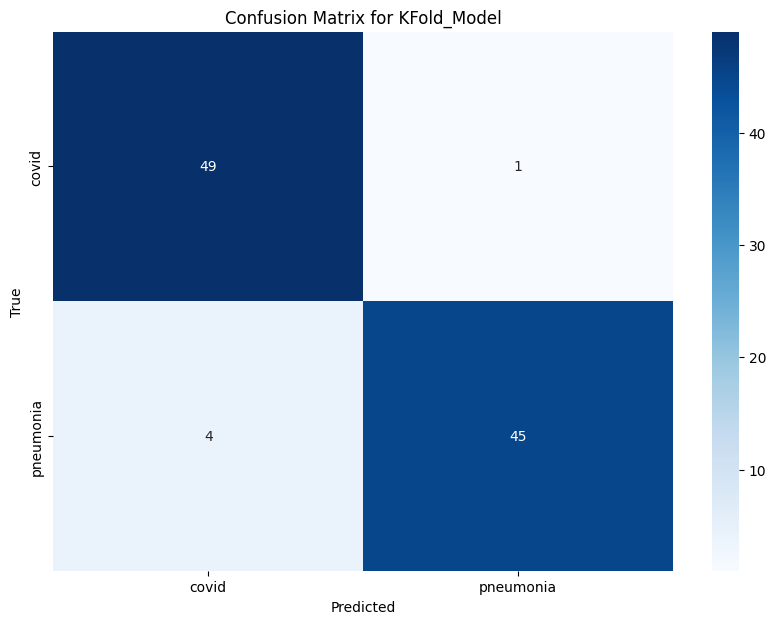


Average Validation Accuracy across 5 folds: 0.8734
Average Validation Loss across 5 folds: 0.3193
Average Training Time per fold: 95.44 seconds


In [20]:
# Train ResNet50 Model

# Now loop over folds instead of manually splitting
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
base_model_resnet.trainable = False

history, avg_accuracy, avg_loss, conf_matrix, class_report, Y_test, Y_pred_classes = build_and_train_model_kfold(
    base_model=base_model_resnet,
    X=X_train,
    Y=Y_train,
    X_test=X_test,
    Y_test=Y_test,
    labels=labels,
    model_name='KFold_Model',
    k_folds=5
)

# history_resnet, time_resnet, conf_matrix_resnet, report_resnet, Y_test_resnet, Y_pred_resnet = build_and_train_model(base_model_resnet, X_train, Y_train, X_test, Y_test, labels, 'ResNet50')



Number of devices: 2

Training Fold 1/5...

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 601ms/step - accuracy: 0.6861 - loss: 8.6757 - val_accuracy: 0.9241 - val_loss: 1.6162
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 561ms/step - accuracy: 0.9114 - loss: 2.0241 - val_accuracy: 0.9367 - val_loss: 1.8541
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 534ms/step - accuracy: 0.9231 - loss: 1.7216 - val_accuracy: 0.9747 - val_loss: 0.1168
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 530ms/step - accuracy: 0.9620 - loss: 0.9224 - val_accuracy: 0.9873 - val_loss: 0.2339
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 532ms/step - accuracy: 0.9637 - loss: 0.8747 - val_accuracy: 1.0000 - val_loss: 3.5082e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.9922 - loss: 0.0202
Fold 1 Validation Accuracy: 1.0000
Fold 1 Validation Loss: 0.0092

Training Fold 2/5...

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 649ms/step - accuracy: 0.6193 - loss: 13.0966 - val_accuracy: 0.9367 - val_loss: 0.4879
Epoch 2/5
10/10 ━━━━━

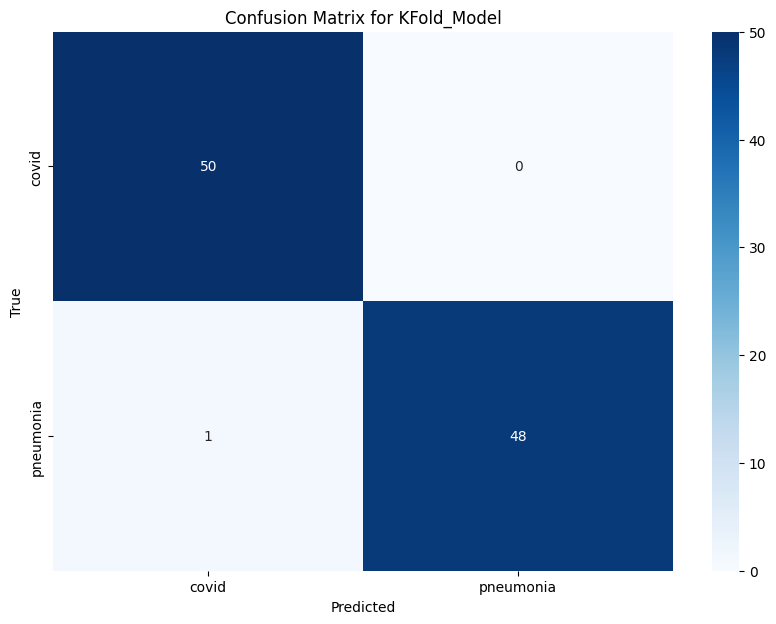


Average Validation Accuracy across 5 folds: 0.9772
Average Validation Loss across 5 folds: 0.1037
Average Training Time per fold: 72.48 seconds


In [12]:
# Train VGG16 Model
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
base_model_vgg.trainable = False

history, avg_accuracy, avg_loss, conf_matrix, class_report, Y_test, Y_pred_classes = build_and_train_model_kfold(
    base_model=base_model_vgg,
    X=X_train,
    Y=Y_train,
    X_test=X_test,
    Y_test=Y_test,
    labels=labels,
    model_name='KFold_Model',
    k_folds=5
)

In [13]:
def calculate_metrics(conf_matrix, Y_test, Y_pred_classes):
    # Sensitivity (Recall)
    sensitivity = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)

    # Specificity
    specificity = []
    for i in range(len(conf_matrix)):
        true_negatives = np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))
        false_positives = np.sum(np.delete(conf_matrix, i, axis=0)[:, i])
        specificity.append(true_negatives / (true_negatives + false_positives))

    # Cohen's Kappa
    kappa = cohen_kappa_score(Y_test, Y_pred_classes)

    # Classification Report (F1-score included)
    class_report_dict = classification_report(Y_test, Y_pred_classes, target_names=labels, output_dict=True)
    f1_score = {label: class_report_dict[label]['f1-score'] for label in labels}

    return sensitivity, specificity, f1_score, kappa

sensitivity_resnet, specificity_resnet, f1_score_resnet, kappa_resnet = calculate_metrics(conf_matrix_resnet, Y_test_resnet, Y_pred_resnet)
sensitivity_vgg, specificity_vgg, f1_score_vgg, kappa_vgg = calculate_metrics(conf_matrix_vgg, Y_test_vgg, Y_pred_vgg)

NameError: name 'conf_matrix_resnet' is not defined

In [ ]:
print("ResNet50 Metrics:")
print(f"Sensitivity (Recall): {sensitivity_resnet}")
print(f"Specificity: {specificity_resnet}")
print(f"F1 Score: {f1_score_resnet}")
print(f"Cohen's Kappa: {kappa_resnet}")

print("\nVGG16 Metrics:")
print(f"Sensitivity (Recall): {sensitivity_vgg}")
print(f"Specificity: {specificity_vgg}")
print(f"F1 Score: {f1_score_vgg}")
print(f"Cohen's Kappa: {kappa_vgg}")

In [ ]:
import numpy as np
import hashlib

def get_image_hash(image_array):
    """Compute hash of an image numpy array to detect duplicates."""
    hasher = hashlib.md5()
    hasher.update(image_array.tobytes())  # Convert image array to bytes
    return hasher.hexdigest()

def check_duplicate_images(X_train, X_val, X_test):
    """Checks for duplicate images across train, validation, and test sets."""
    sets = {'train': X_train, 'val': X_val, 'test': X_test}
    hash_dict = {}

    for split, images in sets.items():
        for i, img in enumerate(images):
            img_hash = get_image_hash(img)
            if img_hash in hash_dict:
                print(f"⚠️ Duplicate image found between {split} and {hash_dict[img_hash]}!")
            hash_dict[img_hash] = split  # Store where the hash was first seen

    print("✅ No duplicate images found between train, val, and test sets!")

# Run check
check_duplicate_images(X_train, X_val, X_test)
